# Testing Misc Methods

## Dataloader with augmentation test

# Inference AlphaPilot Test

Constructing DeepLabv3+ model...
Number of classes: 2
Output stride: 8
Number of Input Channels: 3


/home/shrek/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


mask shape: (512, 512) mask dtype: uint8 mask max value: 255


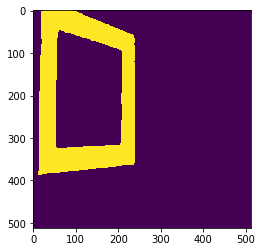

In [2]:
import cv2
from inference_alphapilot import inferenceAlphaPilot
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


inference = inferenceAlphaPilot(checkpoint_path = 'checkpoint/checkpoint.pth'
                                )
pathInputImage = 'data/dataset/test/images/IMG_0008.JPG'
img =cv2.imread(pathInputImage)
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = inference.inferenceOnNumpy(img)
print('mask shape:', mask.shape, 'mask dtype:', mask.dtype,'mask max value:', np.amax(mask))

plt.imshow(mask)

